In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


from src.data.utils import load_tables, load_metadata

In [111]:
def visualize_conditional_embeddings(metadata, run):
    embeddings = dict()
    for table in metadata.get_tables():
        embeddings[table] = np.load(f'../ckpt/{table}/{run}/cond_train_z.npy')

    fig, axes = plt.subplots(1, len(embeddings), figsize=(len(embeddings) * 5, 5))
    cmap = plt.get_cmap('Set1')
    for i, (table, embedding) in enumerate(embeddings.items()):
        pca = PCA(n_components=2)
        pca.fit(embedding)
        embedding = pca.transform(embedding)
        axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10, color=cmap(i))
        axes[i].set_title(table)
        axes[i].axis('equal')
    plt.tight_layout()
    fig.suptitle(f'Conditional Embeddings')

In [112]:
def viszalize_gin_embeddings(dataset_name, metadata):
    embeddings = dict()
    for table in metadata.get_tables():
        embeddings[table] = pd.read_csv(f'../data/gin_embeddings/{dataset_name}/{table}_embeddings.csv', index_col=0)

    fig, axes = plt.subplots(1, len(embeddings), figsize=(len(embeddings) * 5, 5))
    cmap = plt.get_cmap('Set1')
    for i, (table, embedding) in enumerate(embeddings.items()):
        pca = PCA(n_components=2)
        pca.fit(embedding)
        embedding = pca.transform(embedding)
        axes[i].scatter(embedding[:, 0], embedding[:, 1], s=10, color=cmap(i))
        axes[i].set_title(table)
        axes[i].axis('equal')
    plt.tight_layout()
    fig.suptitle(f'GIN Embeddings')

In [113]:
def visualize_hetero_gnn_embeddings(metadata):
    fig, axes = plt.subplots(1, len(metadata.get_tables()), figsize=(len(metadata.get_tables()) * 5, 5))
    cmap = plt.get_cmap('Set1')
    for i, table in enumerate(metadata.get_tables()):
        hetero_gnn_embeddings = np.load(f'../data/embeddings/{table}_embeddings.npy')
        pca = PCA(n_components=3)
        pca.fit(hetero_gnn_embeddings)
        hetero_gnn_embeddings = pca.transform(hetero_gnn_embeddings)
        axes[i].scatter(hetero_gnn_embeddings[:, 0], hetero_gnn_embeddings[:, 1], s=10, color=cmap(i))
        axes[i].set_title(table)
        axes[i].axis('equal')
    plt.tight_layout()
    fig.suptitle(f'HeteroGNN Embeddings')

In [114]:
def visualize_tables(dataset_name, metadata, k=10):
    tables = load_tables(dataset_name, split='train')
    label_encoders = {}
    cluster = {}

    data_types = {}
    table_clusters = {}
    for table in metadata.get_tables():
        data_types[table] = metadata.get_dtypes(table)
        for column, dtype in data_types[table].items():
            if dtype == 'object':
                label_encoders[column] = LabelEncoder()
                label_encoders[column].fit(tables[table][column])
                tables[table][column] = label_encoders[column].transform(tables[table][column])
            elif dtype == 'datetime64[ns]' or dtype == 'datetime64':
                tables[table][column] = pd.to_numeric(pd.to_datetime(tables[table][column]))
                
        tables[table].pop(metadata.get_primary_key(table))
        for parent in metadata.get_parents(table):
            for fk in metadata.get_foreign_keys(parent, table):
                tables[table].pop(fk)
        # standardize the data
        tables[table] = (tables[table] - tables[table].mean()) / tables[table].std()
        if len(tables[table].columns) > 2:
            cluster[table] = KMeans(n_clusters=k, n_init='auto').fit(tables[table].to_numpy())
        else:
            cluster[table] = KMeans(n_clusters=tables[table].iloc[:,0].unique().shape[0], n_init='auto').fit(tables[table].to_numpy())
        table_clusters[table] = cluster[table].transform(tables[table].to_numpy()).argmin(axis=1)

    fig, axes = plt.subplots(1, len(metadata.get_tables()), figsize=(len(metadata.get_tables()) * 5, 5))
    cmap = plt.get_cmap('Set1')
    for i, table in enumerate(metadata.get_tables()):
        if len(tables[table].columns) > 2:
            pca = PCA(n_components=2)
        else:
            pca = PCA(n_components=1)
        pca.fit(tables[table])
        table_data = pca.transform(tables[table])
        for j in range(k):
            if len(tables[table].columns) > 2:
                axes[i].scatter(table_data[table_clusters[table] == j, 0], table_data[table_clusters[table] == j, 1], s=10, color=cmap(j))
            else:
                axes[i].scatter(table_data[table_clusters[table] == j, 0], np.zeros_like(table_data[table_clusters[table] == j, 0]), s=10, color=cmap(j))
        axes[i].set_title(table)
    plt.tight_layout()
    fig.suptitle(f'KMeans Embeddings in PCA Space')

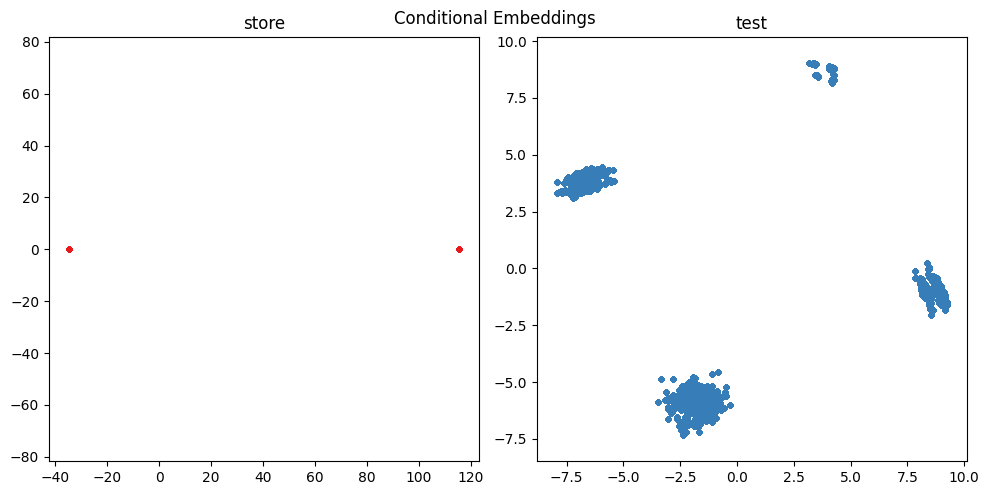

In [115]:
metadata = load_metadata('rossmann-store-sales')
run = 'GIN_DEG_COND_MLP'
visualize_conditional_embeddings(metadata, run)

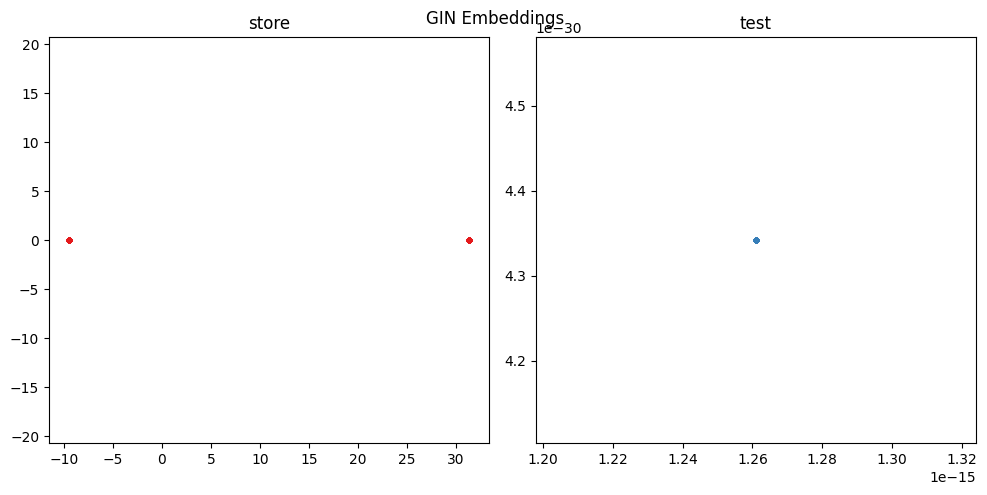

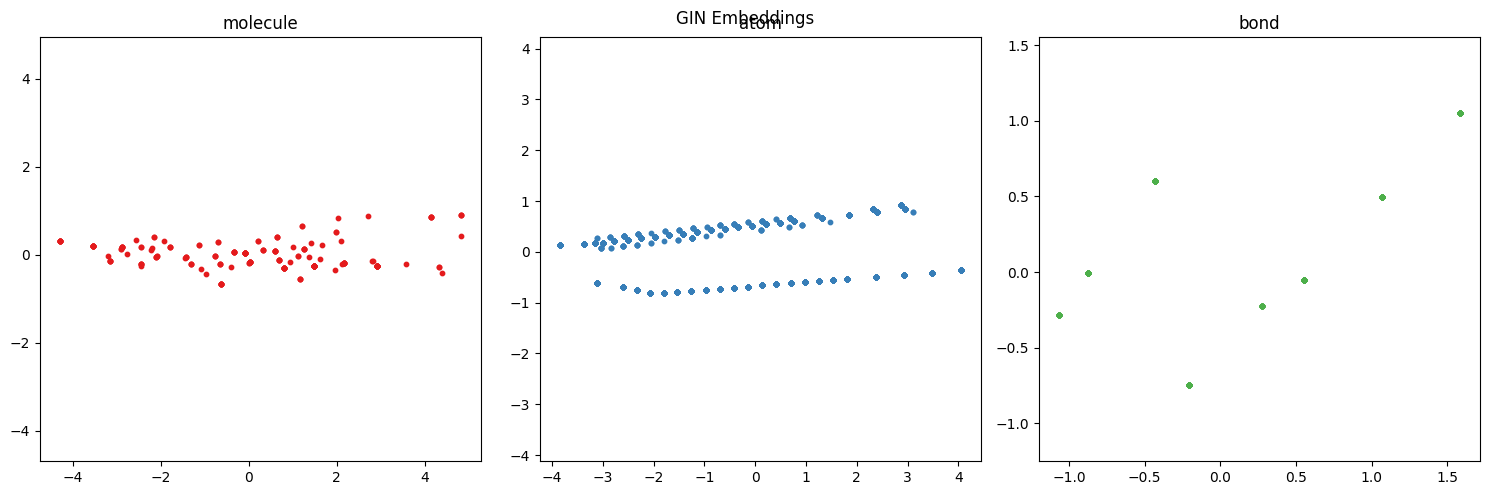

In [116]:
dataset_name = 'rossmann-store-sales'
metadata = load_metadata(dataset_name)
viszalize_gin_embeddings(dataset_name, metadata)
dataset_name = 'mutagenesis'
metadata = load_metadata(dataset_name)
viszalize_gin_embeddings(dataset_name, metadata)

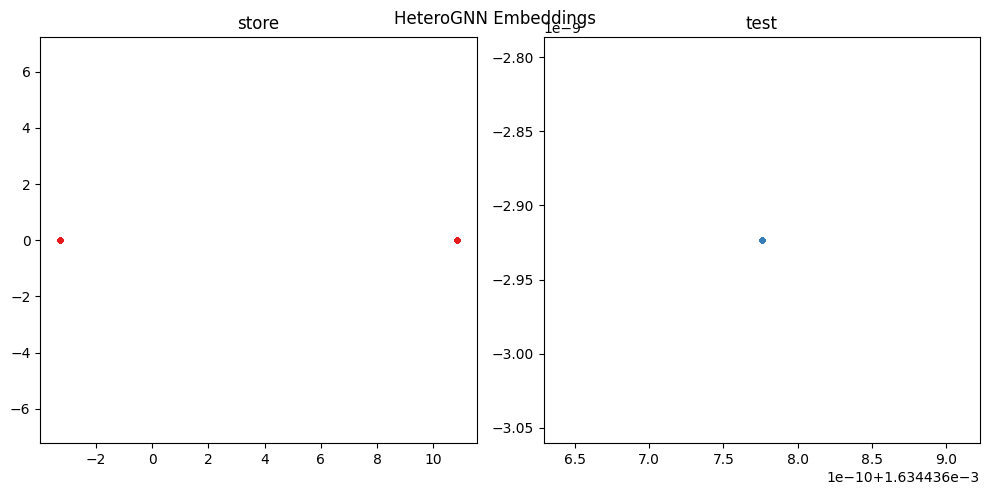

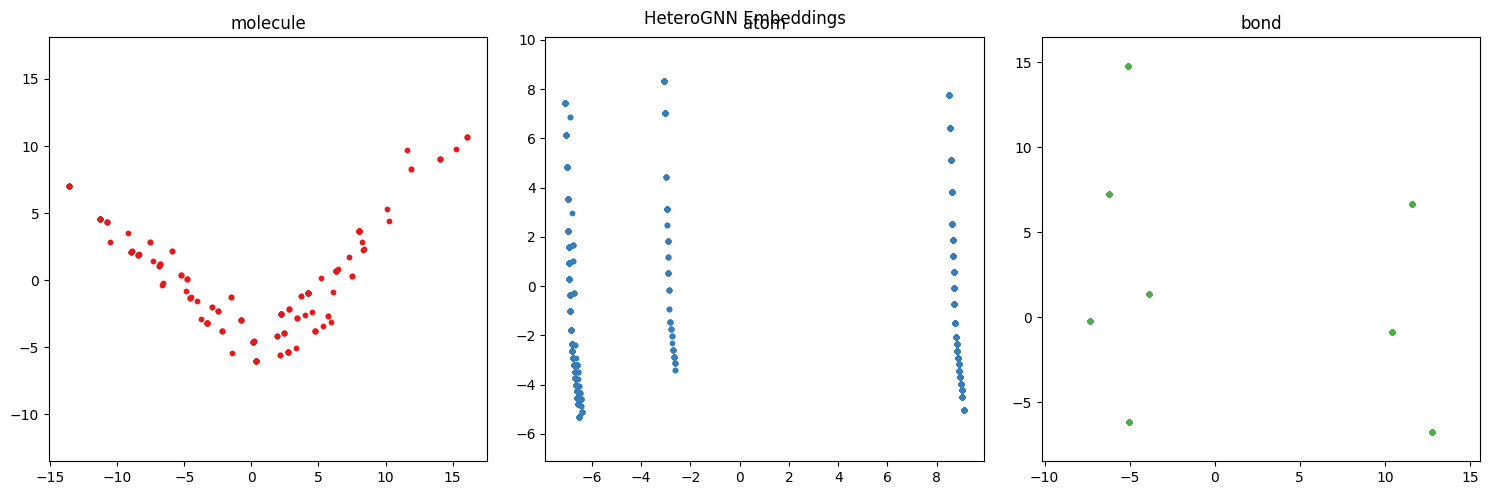

In [117]:
metadata = load_metadata('rossmann-store-sales')
visualize_hetero_gnn_embeddings(metadata)

metadata = load_metadata('mutagenesis')
visualize_hetero_gnn_embeddings(metadata)    

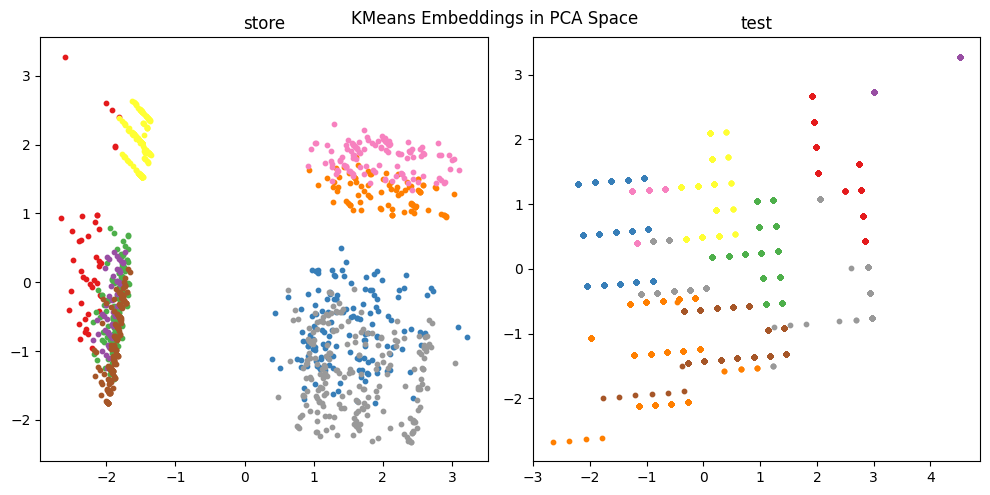

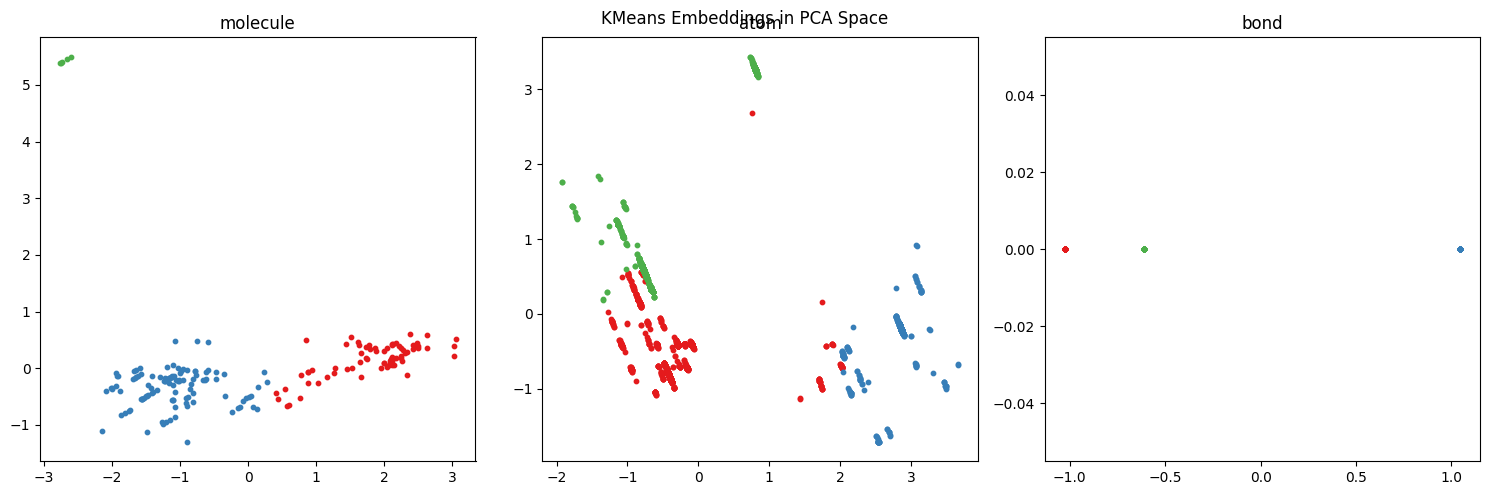

In [118]:
metadata = load_metadata('rossmann-store-sales')
visualize_tables('rossmann-store-sales', metadata, k=10)
metadata = load_metadata('mutagenesis')
visualize_tables('mutagenesis', metadata, k=3)